En esta primera parte voy a agarrar el df que combina los 4 datasets y voy a probar cuál de las tres normalizaciones da mejor. 

In [24]:
# ---- Packages -----
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics as sklmt
random.seed(42)

In [2]:
def PR_curve(model, X_test, y_test, titulo):
    from sklearn.metrics import precision_recall_curve, accuracy_score, auc
    from matplotlib import pyplot
    import numpy as np

    # predict probabilities
    yhat = model.predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_test, yhat)
    
    # convert to f score
    numerator = 2 * recall * precision
    denom = recall + precision
    fscore = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    # Compute predictions based on the threshold that maximizes F-Score
    y_pred = np.where(yhat >= thresholds[ix], 1, 0)
    
    # Compute accuracy using the predictions
    accuracy = accuracy_score(y_test, y_pred)
    
    # Compute AUC
    auc_score = auc(recall, precision)
    
    # Generate dummy data for a perfect model
    y_true = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    y_scores = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    # Compute precision and recall values using scikit-learn's precision_recall_curve
    precision_perfect, recall_perfect, _ = precision_recall_curve(y_true, y_scores)

    # Plot the precision-recall curve
    pyplot.plot(recall_perfect, precision_perfect, linestyle='--', color='green', lw=2, label='Perfect model')
    pyplot.plot(recall, precision, marker='.', label='Random Forest', color='hotpink')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend(fontsize='small')
    pyplot.title(titulo)
    
    # show the plot
    pyplot.show()
    print('Best Threshold=%f, F-Score=%.3f, Accuracy=%.3f, AUC=%.3f' % (thresholds[ix], fscore[ix], accuracy, auc_score))
    return thresholds[ix], fscore[ix], accuracy, auc_score



In [25]:
# Diccionario para almacenar los DataFrames
dataframes = {}

# Nombres de los archivos CSV
file_names = [r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_mirza_tpm.csv", 
              r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_mirza_tpmclr.csv", 
              r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_mirza_tmm.csv", 
              r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_tpm.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_tpmclr.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_tmm.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_mirza_tpm.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_mirza_tpmclr.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_mirza_tmm.csv",
             r"..\Archivos\Datasets_normalizados\boeck_gomez_tpm.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_tpmclr.csv",
              r"..\Archivos\Datasets_normalizados\boeck_gomez_tmm.csv",
             r"..\Archivos\Datasets_normalizados\boeck_kalesky_mirza_tpm.csv",
              r"..\Archivos\Datasets_normalizados\boeck_kalesky_mirza_tpmclr.csv",
              r"..\Archivos\Datasets_normalizados\boeck_kalesky_mirza_tmm.csv",
             r"..\Archivos\Datasets_normalizados\boeck_kalesky_tpm.csv",
             r"..\Archivos\Datasets_normalizados\boeck_kalesky_tpmclr.csv",
             r"..\Archivos\Datasets_normalizados\boeck_kalesky_tmm.csv",
             r"..\Archivos\Datasets_normalizados\boeck_mirza_tpm.csv",
             r"..\Archivos\Datasets_normalizados\boeck_mirza_tpmclr.csv",
             r"..\Archivos\Datasets_normalizados\boeck_mirza_tmm.csv",
             r'..\Archivos\Datasets_normalizados\boeck_tmm.csv',
             r'..\Archivos\Datasets_normalizados\boeck_tpm.csv',
             r'..\Archivos\Datasets_normalizados\boeck_tpmclr.csv']

# Leer cada archivo CSV y cargarlo como un DataFrame, luego agregarlo al diccionario
for file_name in file_names:
    df_name = os.path.splitext(os.path.basename(file_name))[0]  # Extraer el nombre base sin extensión
    df = pd.read_csv(file_name)
    dataframes[df_name] = df

In [11]:
#Abrir datos de entrenamiento
def leer_lista(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        return [line.strip() for line in file]

# Leer las listas desde los archivos de texto
X_test = leer_lista(r"..\Archivos\Genes_entrenamiento\X_test.txt")
X_train = leer_lista(r"..\Archivos\Genes_entrenamiento\X_train.txt")

In [16]:
#Abrimos los ejemplos positivos y negativos
#Abrir tabla en donde están relevados los genes de la cadena
genes = pd.read_csv(r"..\Archivos\Genes_entrenamiento\Genes_cadena.csv",
                   sep = ',')
# Filtrar el DataFrame para seleccionar las filas que cumplan la condición
filas_seleccionadas = genes[genes['Usar para entrenar'] == 'si']

# Obtener los valores de la columna 'WBID' para las filas seleccionadas
muestra_positiva = filas_seleccionadas['WBID'].tolist()
len(muestra_positiva)

#Abrir la lista de genes que pertenecen al cluster B del grafo
file_name = r"..\Archivos\Genes_entrenamiento\genes_cluster_B.txt"

# Lista para almacenar los genes negativos
muestra_negativa = []

# Leer el archivo y guardar los genes negativos en la lista
with open(file_name, "r") as file:
    for line in file:
        gene = line.strip()  # Eliminar espacios en blanco y saltos de línea alrededor del gen
        muestra_negativa.append(gene)
len(muestra_negativa)

282

In [27]:
#Chequeamos que los genes X estén en los dfs

def chequear_train(sample, dataframes):
    # Lista para almacenar los genes faltantes en los dataframes
    genes_faltantes_por_df = {}
    # Iterar sobre cada DataFrame en dataframes
    for nombre_df, df in dataframes.items():
        # Encontrar los genes faltantes en el DataFrame actual
        genes_faltantes = [gen for gen in sample if gen not in df['Gene'].values]
        # Agregar los genes faltantes al diccionario genes_faltantes_por_df
        genes_faltantes_por_df[nombre_df] = genes_faltantes
        if not genes_faltantes:
            pass
        else:
            for i in genes_faltantes:
                sacar.append(i)

    # Verificar los genes faltantes en cada DataFrame
    for nombre_df, genes_faltantes in genes_faltantes_por_df.items():
        if len(genes_faltantes) > 0:
            print(f"Los siguientes genes están faltantes en el DataFrame {nombre_df}: {genes_faltantes}")
        else:
            print(f"No hay genes faltantes en el DataFrame {nombre_df}")

In [28]:
chequear_train(X_train, dataframes)
chequear_train(X_test, dataframes)

No hay genes faltantes en el DataFrame boeck_gomez_kalesky_mirza_tpm
No hay genes faltantes en el DataFrame boeck_gomez_kalesky_mirza_tpmclr
No hay genes faltantes en el DataFrame boeck_gomez_kalesky_mirza_tmm
No hay genes faltantes en el DataFrame boeck_gomez_kalesky_tpm
No hay genes faltantes en el DataFrame boeck_gomez_kalesky_tpmclr
No hay genes faltantes en el DataFrame boeck_gomez_kalesky_tmm
No hay genes faltantes en el DataFrame boeck_gomez_mirza_tpm
No hay genes faltantes en el DataFrame boeck_gomez_mirza_tpmclr
No hay genes faltantes en el DataFrame boeck_gomez_mirza_tmm
No hay genes faltantes en el DataFrame boeck_gomez_tpm
No hay genes faltantes en el DataFrame boeck_gomez_tpmclr
No hay genes faltantes en el DataFrame boeck_gomez_tmm
No hay genes faltantes en el DataFrame boeck_kalesky_mirza_tpm
No hay genes faltantes en el DataFrame boeck_kalesky_mirza_tpmclr
No hay genes faltantes en el DataFrame boeck_kalesky_mirza_tmm
No hay genes faltantes en el DataFrame boeck_kalesky

Para ir almacenando los datos del entrenamiento, creamos un df

In [29]:
# Diccionario para almacenar los datos de train y test para cada DataFrame
datos_train_test_por_df = {}

# Iterar sobre cada DataFrame en dataframes
for nombre_df, df in dataframes.items():
    # Crear un diccionario para almacenar los datos de train y test
    datos_train_test = {'train': {}, 'test': {}}
    
    # Obtener los datos de entrenamiento del DataFrame actual
    print(nombre_df)
    train_data = df[df['Gene'].isin(X_train)].drop(columns=['Gene']).values
    genes_train = list(df[df['Gene'].isin(X_train)]['Gene'])
    datos_train_test['train']['data'] = train_data
    datos_train_test['train']['classes'] = [1 if gen in muestra_positiva else 0 for gen in genes_train]
    
    # Obtener los datos de prueba del DataFrame actual
    test_data = df[df['Gene'].isin(X_test)].drop(columns=['Gene']).values
    datos_train_test['test']['data'] = test_data
    genes_test = list(df[df['Gene'].isin(X_test)]['Gene'])
    datos_train_test['test']['classes'] = [1 if gen in muestra_positiva else 0 for gen in genes_test]
    
    # Agregar los datos de train y test al diccionario de datos_train_test_por_df
    datos_train_test_por_df[nombre_df] = datos_train_test

boeck_gomez_kalesky_mirza_tpm
boeck_gomez_kalesky_mirza_tpmclr
boeck_gomez_kalesky_mirza_tmm
boeck_gomez_kalesky_tpm
boeck_gomez_kalesky_tpmclr
boeck_gomez_kalesky_tmm
boeck_gomez_mirza_tpm
boeck_gomez_mirza_tpmclr
boeck_gomez_mirza_tmm
boeck_gomez_tpm
boeck_gomez_tpmclr
boeck_gomez_tmm
boeck_kalesky_mirza_tpm
boeck_kalesky_mirza_tpmclr
boeck_kalesky_mirza_tmm
boeck_kalesky_tpm
boeck_kalesky_tpmclr
boeck_kalesky_tmm
boeck_mirza_tpm
boeck_mirza_tpmclr
boeck_mirza_tmm
boeck_tmm
boeck_tpm
boeck_tpmclr


In [30]:
#chequear que los X e y tengan la misma cantidad de datos.
print(len(datos_train_test_por_df['boeck_kalesky_tpm']['train']['data']))
print(len(datos_train_test_por_df['boeck_kalesky_tpm']['train']['classes']))

102
102


In [31]:
# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'n_estimators': np.arange(1, 20, 1),
    'max_depth': np.arange(1, 20, 2),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 1)
}
param_grid

{'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),
 'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])}

In [32]:
# Definir el modelo RandomForest
modelo_rf = RandomForestClassifier(random_state=42)

modelos_rf_por_df = {}

for nombre_df, datos in datos_train_test_por_df.items():
    # Obtener los datos de entrenamiento y las clases correspondientes
    X_train = datos['train']['data']
    y_train = datos['train']['classes']
    
    # Inicializar y entrenar el modelo Random Forest
    grid_search = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, n_jobs= 4 , cv=5, scoring='f1')

    # Entrenar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)
    
    # Guardar el modelo entrenado en el diccionario de modelos_rf_por_df
    modelos_rf_por_df[nombre_df] = grid_search
    
    mejores_parametros = grid_search.best_params_
    mejor_puntaje = grid_search.best_score_
    
    # Imprimir los mejores parámetros y el mejor puntaje
    print(f"Best F1 score: {mejor_puntaje:.3f} with hyperparameters: {mejores_parametros}") 

    # Predecir las clases para el conjunto de prueba y calcular la precisión
    X_test = datos['test']['data']
    y_test = datos['test']['classes']
    y_pred = grid_search.predict(X_test)
    
    accuracy = sklmt.accuracy_score(y_test, y_pred)
    f1 = sklmt.f1_score(y_test, y_pred, average = 'binary', pos_label= 1)
    
    print(f"Precision del modelo para el DataFrame {nombre_df}: {accuracy}")
    print(f"F1 del modelo para el DataFrame {nombre_df}: {f1}")

Best F1 score: 0.989 with hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
Precision del modelo para el DataFrame boeck_gomez_kalesky_mirza_tpm: 0.9411764705882353
F1 del modelo para el DataFrame boeck_gomez_kalesky_mirza_tpm: 0.9473684210526315
Best F1 score: 0.839 with hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4}
Precision del modelo para el DataFrame boeck_gomez_kalesky_mirza_tpmclr: 0.8529411764705882
F1 del modelo para el DataFrame boeck_gomez_kalesky_mirza_tpmclr: 0.8648648648648649
Best F1 score: 0.979 with hyperparameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
Precision del modelo para el DataFrame boeck_gomez_kalesky_mirza_tmm: 0.9411764705882353
F1 del modelo para el DataFrame boeck_gomez_kalesky_mirza_tmm: 0.9500000000000001
Best F1 score: 0.962 with hyperparameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split':

In [33]:
import pickle
# Guardar el diccionario en un archivo
with open('..\Archivos\Modelos_normalizacion.pickle', 'wb') as archivo:
    pickle.dump(modelos_rf_por_df, archivo)

In [49]:
import pickle

# # Abrir el archivo y cargar el diccionario
# with open('..\Archivos\Modelos_normalizacion.pickle', 'rb') as archivo:
#     modelos_rf_por_df = pickle.load(archivo)

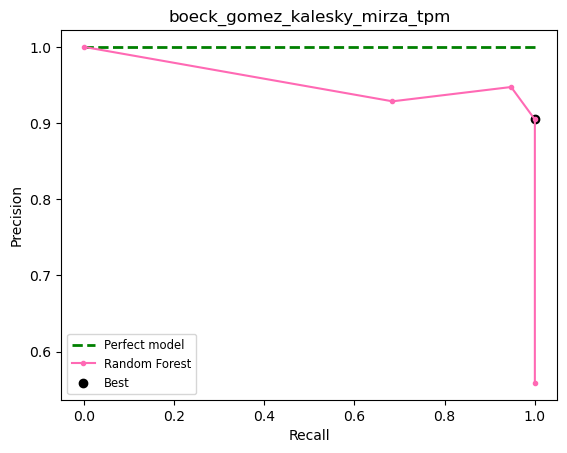

Best Threshold=0.333333, F-Score=0.950, Accuracy=0.941, AUC=0.955


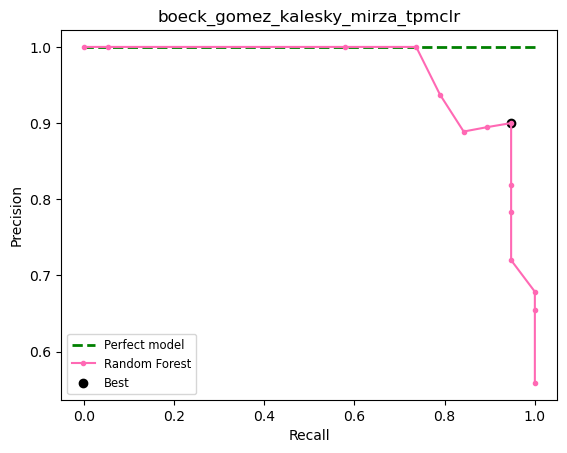

Best Threshold=0.493590, F-Score=0.923, Accuracy=0.912, AUC=0.967


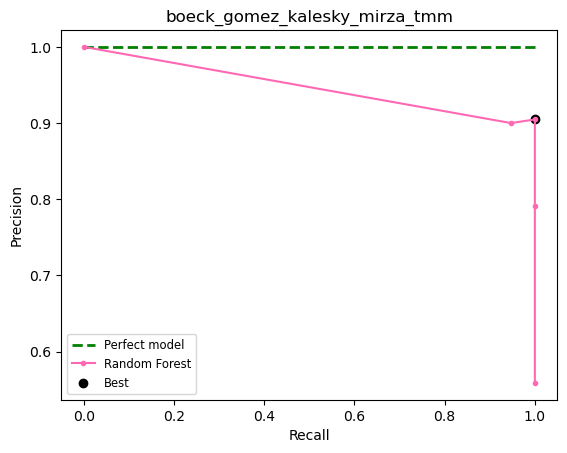

Best Threshold=0.630952, F-Score=0.950, Accuracy=0.941, AUC=0.947


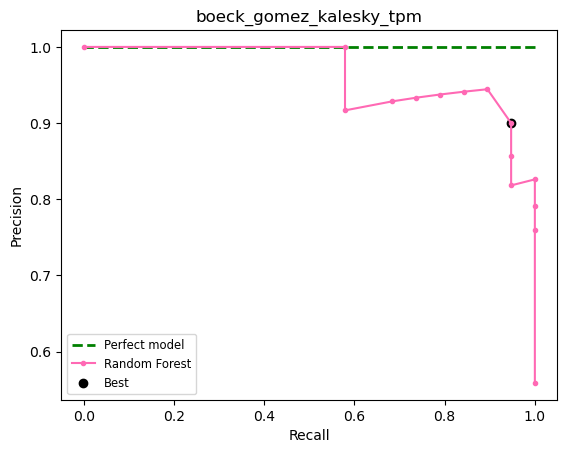

Best Threshold=0.622868, F-Score=0.923, Accuracy=0.912, AUC=0.965


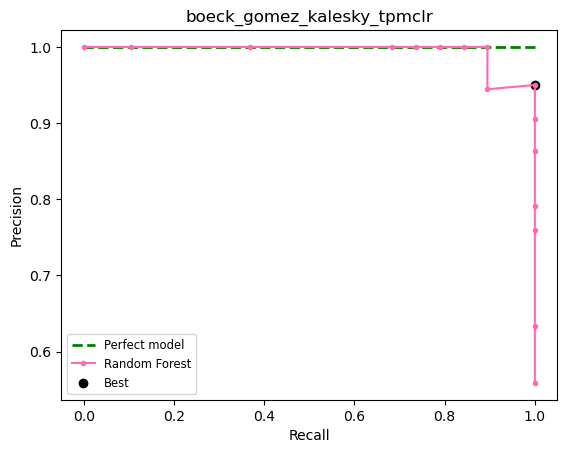

Best Threshold=0.266667, F-Score=0.974, Accuracy=0.971, AUC=0.994


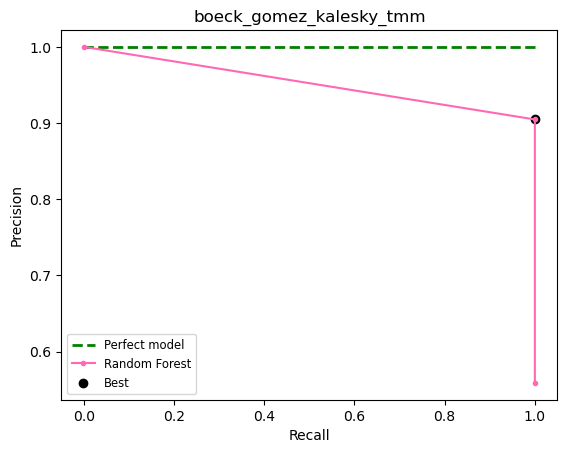

Best Threshold=1.000000, F-Score=0.950, Accuracy=0.941, AUC=0.952


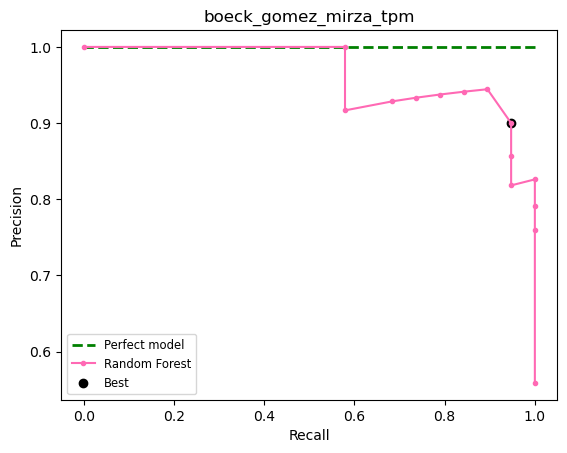

Best Threshold=0.622868, F-Score=0.923, Accuracy=0.912, AUC=0.965


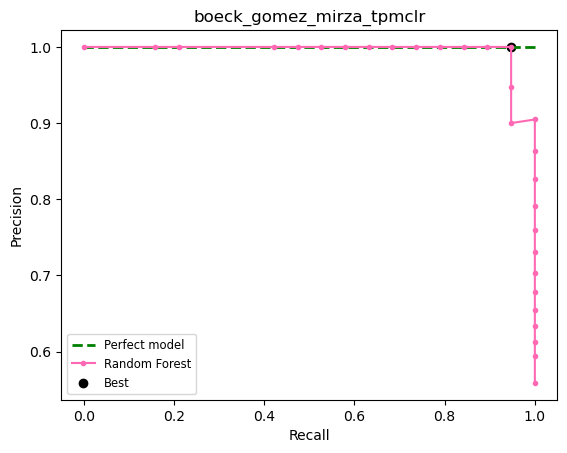

Best Threshold=0.599369, F-Score=0.973, Accuracy=0.971, AUC=0.995


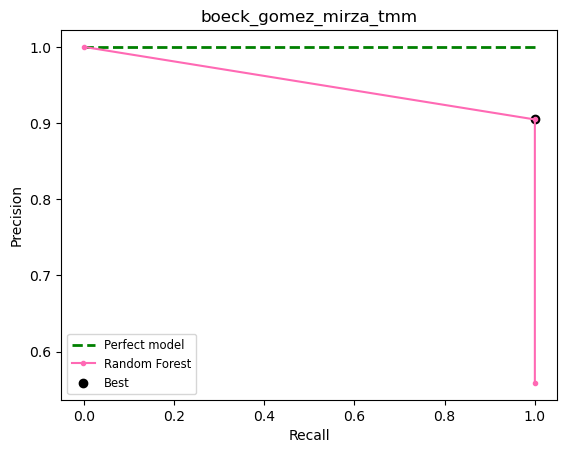

Best Threshold=1.000000, F-Score=0.950, Accuracy=0.941, AUC=0.952


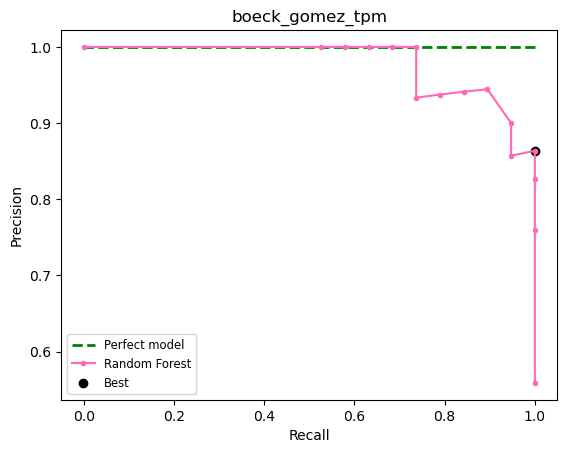

Best Threshold=0.281676, F-Score=0.927, Accuracy=0.912, AUC=0.979


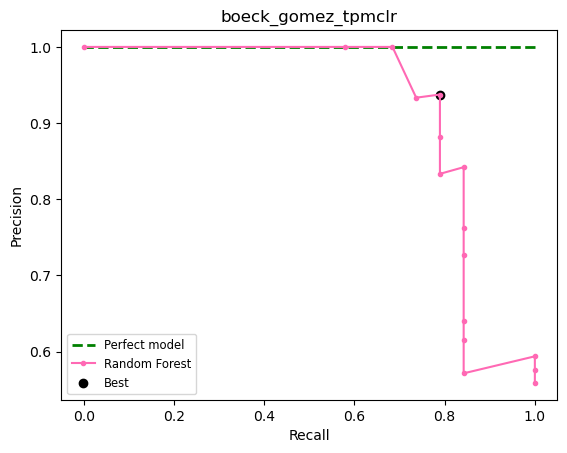

Best Threshold=0.655487, F-Score=0.857, Accuracy=0.853, AUC=0.920


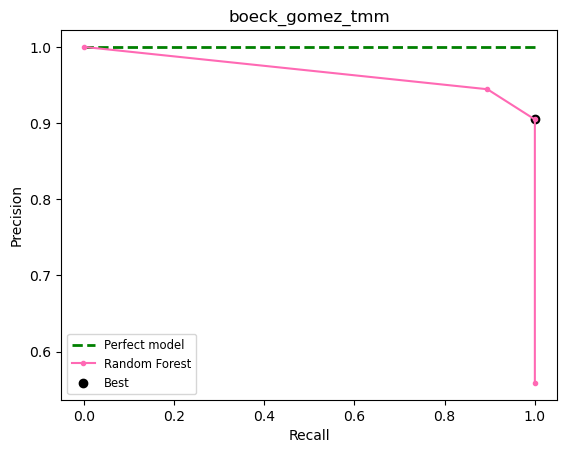

Best Threshold=0.666667, F-Score=0.950, Accuracy=0.941, AUC=0.967


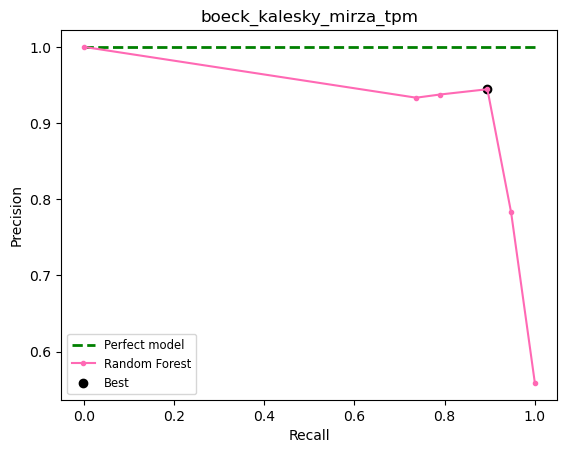

Best Threshold=0.395648, F-Score=0.919, Accuracy=0.912, AUC=0.941


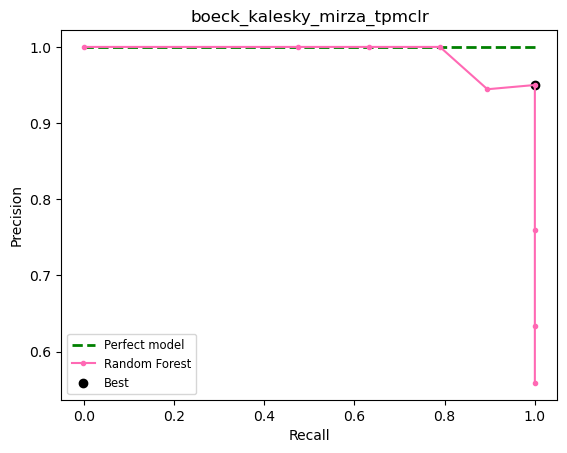

Best Threshold=0.555556, F-Score=0.974, Accuracy=0.971, AUC=0.992


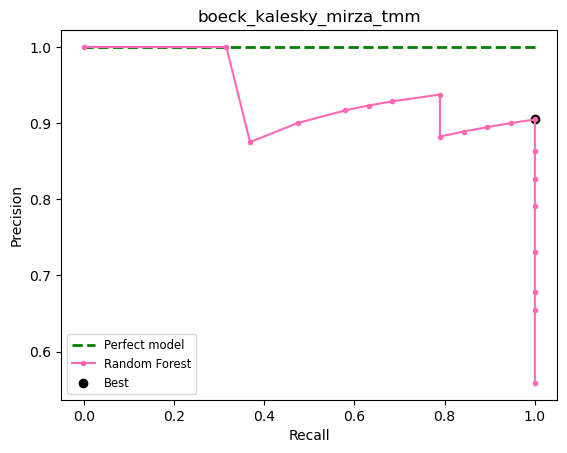

Best Threshold=0.417384, F-Score=0.950, Accuracy=0.941, AUC=0.938


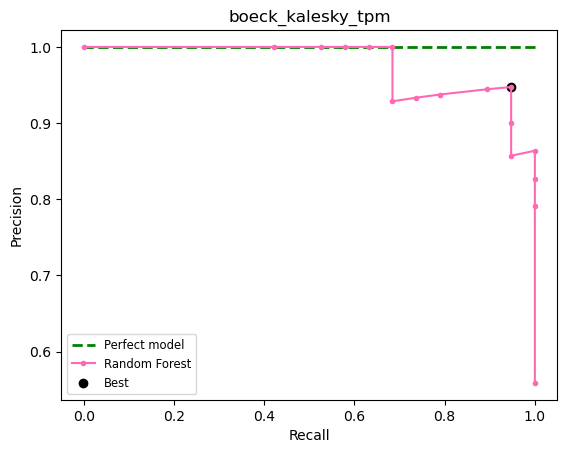

Best Threshold=0.538462, F-Score=0.947, Accuracy=0.941, AUC=0.977


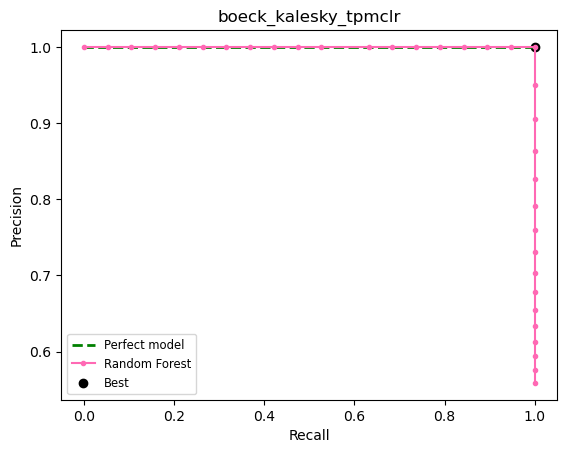

Best Threshold=0.400120, F-Score=1.000, Accuracy=1.000, AUC=1.000


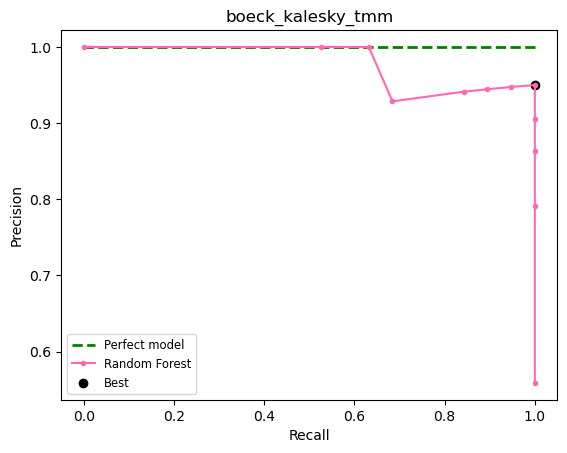

Best Threshold=0.621212, F-Score=0.974, Accuracy=0.971, AUC=0.979


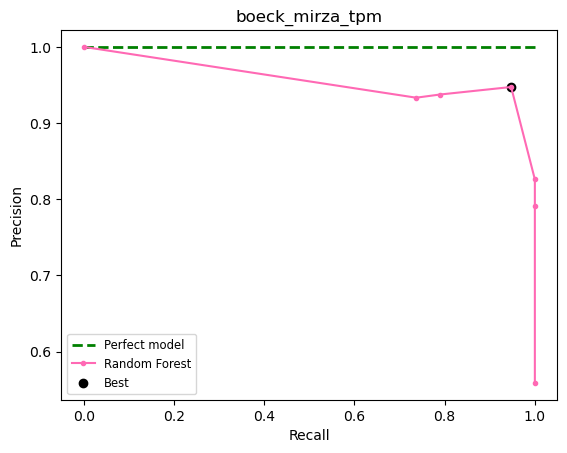

Best Threshold=0.641979, F-Score=0.947, Accuracy=0.941, AUC=0.957


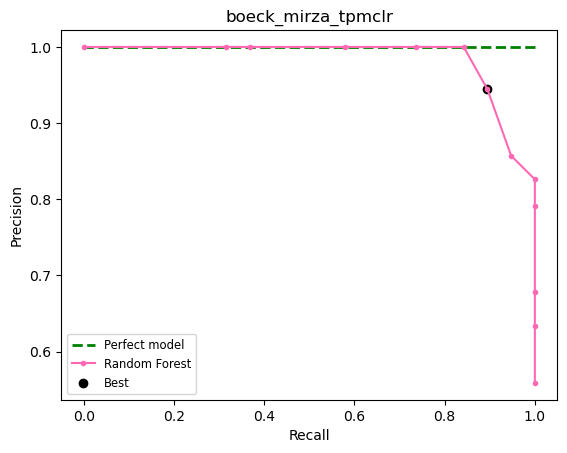

Best Threshold=0.545455, F-Score=0.919, Accuracy=0.912, AUC=0.985


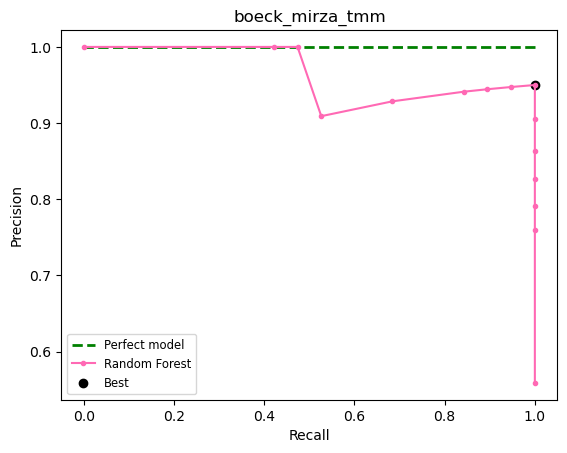

Best Threshold=0.688312, F-Score=0.974, Accuracy=0.971, AUC=0.966


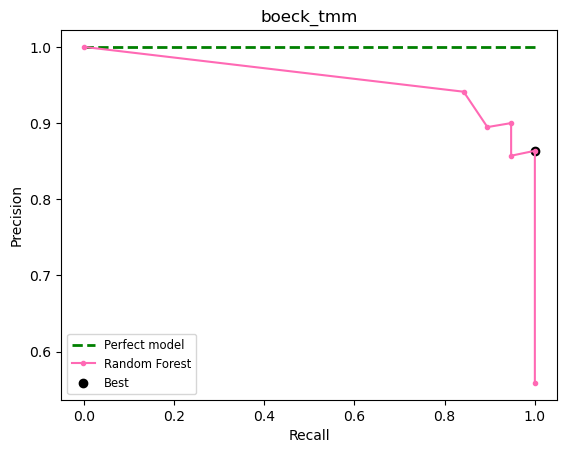

Best Threshold=0.327413, F-Score=0.927, Accuracy=0.912, AUC=0.958


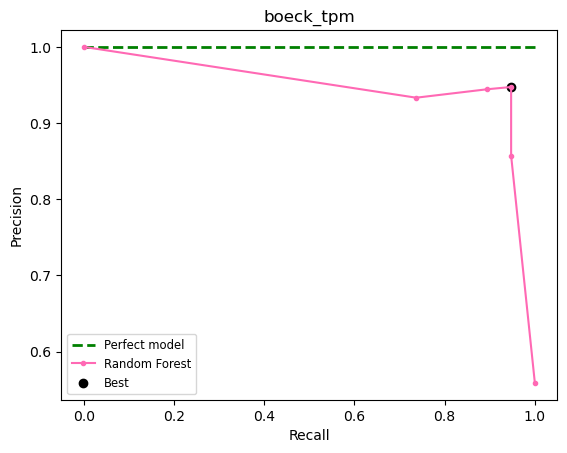

Best Threshold=0.714286, F-Score=0.947, Accuracy=0.941, AUC=0.948


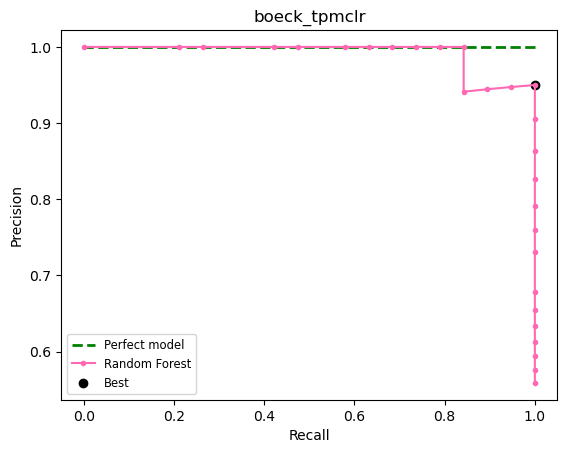

Best Threshold=0.299851, F-Score=0.974, Accuracy=0.971, AUC=0.991


In [34]:
# Crear una lista para almacenar los resultados
resultados = []

# Iterar sobre los datos
for nombre_df, datos in datos_train_test_por_df.items():
    # Obtener los datos de entrenamiento y las clases correspondientes
    X_test = datos['test']['data']
    y_test = datos['test']['classes']
    modelo = modelos_rf_por_df[nombre_df]
    
    # Calcular los resultados utilizando la función PR_curve
    th, f1, ac, auc = PR_curve(modelo, X_test, y_test, nombre_df)
    
    th = round(th, 2)
    f1 = round(f1, 2)
    ac = round(ac, 2)
    auc = round(auc, 2)
    
    # Agregar los resultados a la lista
    resultados.append([nombre_df, th, ac, f1, auc])

    

In [35]:
# Crear un DataFrame a partir de la lista de resultados
df_resultados = pd.DataFrame(resultados, columns=['nombre_df', 'threshold', 'Precisión', 'F1', 'AUC'])
df_resultados.set_index('nombre_df', inplace=True)


In [36]:
df_resultados

,threshold,Precisión,F1,AUC
nombre_df,,,,
boeck_gomez_kalesky_mirza_tpm,0.33,0.94,0.95,0.96
boeck_gomez_kalesky_mirza_tpmclr,0.49,0.91,0.92,0.97
boeck_gomez_kalesky_mirza_tmm,0.63,0.94,0.95,0.95
boeck_gomez_kalesky_tpm,0.62,0.91,0.92,0.97
boeck_gomez_kalesky_tpmclr,0.27,0.97,0.97,0.99
boeck_gomez_kalesky_tmm,1.00,0.94,0.95,0.95
boeck_gomez_mirza_tpm,0.62,0.91,0.92,0.97
boeck_gomez_mirza_tpmclr,0.60,0.97,0.97,0.99
boeck_gomez_mirza_tmm,1.00,0.94,0.95,0.95


In [58]:
# df_resultados.to_csv('resultado_entrenamiento.csv')